In [1]:
import tensorflow as tf

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8194080352843657248
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12730713948950318760
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10521319872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16750402623868818297
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13625559794050065776
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
tf.debugging.set_log_device_placement(True)

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import import_ipynb
import time_data_test as readdata

importing Jupyter notebook from time_data_test.ipynb


In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Masking, Bidirectional
import tensorflow as tf
from sklearn.preprocessing import StandardScaler



<h1> normal data</h1>

In [7]:
#normal data를 그룹핑하고 100개가 넘는 그룹을 골라내기
groupset=[]
over_100_group=[]
for i in range(len(readdata.normal)):
    gb = readdata.normal[i].groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.srcport'])
    for key, group in gb:
        group = np.asarray(group)
        if len(group)>100:
            over_100_group.append(group)
        else :
            groupset.append(group)

In [8]:
for i in range(len(readdata.normal)):
    gb = readdata.normal[i].groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.dstport'])
    for key, group in gb:
        group = np.asarray(group)
        if len(group)>100:
            over_100_group.append(group)
        else :
            groupset.append(group)

In [9]:
#normal data 100개가 넘는 그룹 100개씩 잘라서 그룹셋에 넣기
for i in range(len(over_100_group)):
    for j in range(0,len(over_100_group[i]),100):
        groupset.append(over_100_group[i][j:j+100])


In [10]:
len(groupset)

1339219

In [11]:
for i in range(len(groupset)):
    groupset[i][:,0]=groupset[i][:,0]-groupset[i][0][0]

In [12]:
#100개가 넘는것은 없는지 확인
for i in range(len(groupset)):
    if len(groupset[i])>100:
        print(i)

In [13]:
X=[]
for i in range(len(groupset)):
    temp=np.delete(groupset[i],[1,2,3,4,5],1)
    num=100-len(temp)
    X.append(np.pad(temp,((0,num),(0,0)),'constant', constant_values=-1))

In [14]:
X_data=np.asarray(X)

In [15]:
len(X_data)

1339219

In [16]:
Y_data=[]
for i in range(len(X_data)):
    Y_data.append(0)

In [17]:
len(Y_data)

1339219

In [18]:
X_data.shape

(1339219, 100, 4)

공격데이터

In [20]:
groupset_a=[]
over_100_group_a=[]
gb = readdata.attack.groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.srcport'])
for key, group in gb:
    group = np.asarray(group)
    if len(group)>100:
        over_100_group_a.append(group)
    else :
        groupset_a.append(group)


In [21]:
gb = readdata.attack.groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.dstport'])
for key, group in gb:
    group = np.asarray(group)
    if len(group)>100:
        over_100_group_a.append(group)
    else :
        groupset_a.append(group)


In [23]:
for i in range(len(over_100_group_a)):
    for j in range(0,len(over_100_group_a[i]),100):
        groupset_a.append(over_100_group_a[i][j:j+100])

In [25]:
for i in range(len(groupset_a)):
    groupset_a[i][:,0]=groupset_a[i][:,0]-groupset_a[i][0][0]

In [27]:
X_a=[]
for i in range(len(groupset_a)):
    temp=np.delete(groupset_a[i],[1,2,3,4,5],1)
    num=100-len(temp)
    X_a.append(np.pad(temp,((0,num),(0,0)),'constant', constant_values=-1))

In [29]:
Y_a=[]
for i in range(len(X_a)):
    Y_a.append(1)

In [30]:
X_attack_data=np.asarray(X_a)
Y_attack_data=np.asarray(Y_a)

In [31]:
X_total=np.concatenate((X_data,X_attack_data), axis=0)
#index : 0~891936 까지 normal, 총 891937

In [32]:
X_total.shape

(1339578, 100, 4)

In [33]:
Y_total=np.concatenate((Y_data,Y_attack_data), axis=0)

In [34]:
Y_total.shape

(1339578,)

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X_total,Y_total, test_size=0.2, shuffle=True, stratify=Y_total, random_state=101)

In [37]:
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(1071662, 100, 4) (1071662,) (267916, 100, 4) (267916,)


In [38]:
X_train=X_train.astype('float32')
Y_train=Y_train.astype('float32')
X_test=X_test.astype('float32')
Y_test=Y_test.astype('float32')

In [39]:
from imblearn.over_sampling import SMOTE

In [40]:
smote = SMOTE(random_state=0)

In [41]:
X_train = np.reshape(X_train,(1071662,400))

In [42]:
X_train_over, Y_train_over = smote.fit_sample(X_train, Y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, Y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, Y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(Y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1071662, 400) (1071662,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (2142750, 400) (2142750,)
SMOTE 적용 후 레이블 값 분포: 
 0.0    1071375
1.0    1071375
dtype: int64


In [43]:
X_train = np.reshape(X_train,(1071662,100,4))
X_train_over = np.reshape(X_train_over,(2142750,100,4))

In [44]:
print(X_train_over.shape, Y_train_over.shape)

(2142750, 100, 4) (2142750,)


In [45]:
X_val, X_test, Y_val, Y_test = train_test_split(X_test,Y_test, test_size=0.5,shuffle=True,stratify=Y_test,random_state=101)

In [46]:
print(X_train_over.shape,Y_train_over.shape,X_val.shape,Y_val.shape,X_test.shape,Y_test.shape)

(2142750, 100, 4) (2142750,) (133958, 100, 4) (133958,) (133958, 100, 4) (133958,)


In [47]:
#float type으롤 변경
X_train_over=X_train_over.astype('float32')
Y_train_over=Y_train_over.astype('float32')
X_test=X_test.astype('float32')
Y_test=Y_test.astype('float32')
X_val=X_val.astype('float32')
Y_val=Y_val.astype('float32')

In [50]:
learning_rate = 0.00001
seq_length = 100
data_dim = 4
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy')
]
model = Sequential()
model.add(Masking(mask_value=-1.,input_shape=(100, 4)))
model.add(Bidirectional(LSTM(128, kernel_regularizer='l2', input_shape=(100,4))))

model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=METRICS)
          
history = model.fit(X_train_over, Y_train_over,validation_data=(X_val,Y_val), epochs=60, batch_size=64)

model.save('test_00001_60.h5')

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/60
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing

33481/33481 [==============================] - 500s 15ms/step - loss: 0.0232 - accuracy: 0.9997 - val_loss: 0.0237 - val_accuracy: 0.9992
Epoch 6/60
33481/33481 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9997Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDatase

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
33481/33481 [==============================] - 500s 15ms/step - loss: 0.0175 - accuracy: 0.9997 - val_loss: 0.0180 - val_accuracy: 0.9993
Epoch 14/60
33481/33481 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9997Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDatas

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
33481/33481 [==============================] - 501s 15ms/step - loss: 0.0163 - accuracy: 0.9997 - val_loss: 0.0176 - val_accuracy: 0.9991
Epoch 22/60
33481/33481 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9998Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
33481/33481 [==============================] - 500s 15ms/step - loss: 0.0159 - accuracy: 0.9997 - val_loss: 0.0165 - val_accuracy: 0.9995
Epoch 30/60
33481/33481 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9997Executing op RangeDatas

Epoch 37/60
33481/33481 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9997Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
33481/33481 [==============================] - 501s 15ms/step - loss: 0.0154 - a

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
33481/33481 [==============================] - 500s 15ms/step - loss: 0.0153 - accuracy: 0.9998 - val_loss: 0.0159 - val_accuracy: 0.9994
Epoch 45/60
33481/33481 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9998Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
33481/33481 [==============================] - 501s 15ms/step - loss: 0.0150 - accuracy: 0.9998 - val_loss: 0.0155 - val_accuracy: 0.9996
Epoch 53/60
33481/33481 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9998Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDatas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
33481/33481 [==============================] - 501s 15ms/step - loss: 0.0157 - accuracy: 0.9996 - val_loss: 0.0158 - val_accuracy: 0.9994
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loca

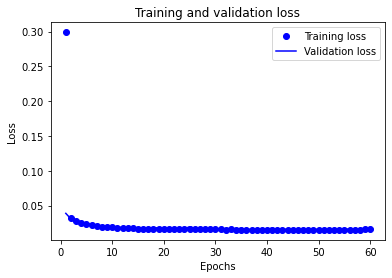

In [51]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')  # ‘bo’는 파란색 점을 의미합니다.
plt.plot(epochs, val_loss, 'b', label='Validation loss') # ‘b’는 파란색 실선을 의미합니다.
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [52]:
X_val_predict = model.predict(X_val,verbose=1)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_4309110 in device /job:localhost/replica:0/task:0/

In [53]:
predict = model.predict(X_test,verbose=1)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
4187/4187 [==============================] - 24s 6ms/step


In [54]:
predict

array([[0.00020917],
       [0.00033905],
       [0.00201952],
       ...,
       [0.00021443],
       [0.00047348],
       [0.00036892]], dtype=float32)

<br>
<h2>X_val_predict로 임계값 구하기</h2>


<h3>roc곡선</h3>

thresholds :  [1. 1. 1. ... 0. 0. 0.]
precisions :  [0.    0.    0.    ... 0.998 0.999 1.   ]
recalls :  [0.028 0.583 0.833 ... 1.    1.    1.   ]


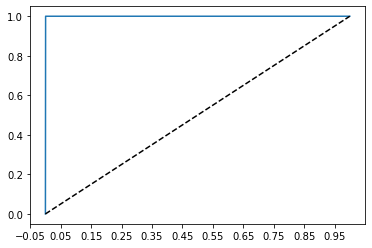

In [55]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

#roc 곡선
fprs, tprs, thresholds = metrics.roc_curve(Y_val,X_val_predict)

thr_index = np.arange(1, thresholds.shape[0], 5)

# 인덱스에 해당하는 정밀도, 재현율, 임계값 구하기
print('thresholds : ', np.round(thresholds[thr_index],2))
print('precisions : ', np.round(fprs[thr_index],3))
print('recalls : ', np.round(tprs[thr_index],3))



# 그래프 그리기
def roc_curve_plot(y_real, pred_prob_1):
    fprs, tprs, thresholds = roc_curve(y_real, pred_prob_1)
    
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1], 'k--',label = 'Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2)) # scale 0.1 단위
    

roc_curve_plot(Y_val,X_val_predict)

In [56]:
def optimal_threshold_roc(tpr, fpr, threshs):
    g_means = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(g_means)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshs[ix], g_means[ix]))
    print('Best tpr=%f, fpr=%f' % (tpr[ix], fpr[ix]))

    return threshs[ix]

threshold_roc=optimal_threshold_roc(tprs, fprs, thresholds)
threshold_roc

Best Threshold=0.940966, G-Mean=1.000
Best tpr=1.000000, fpr=0.000231


0.94096607

<h3>pr 곡선 </h3>

thresholds :  [0.94 0.98 1.   1.  ]
precisions :  [0.537 0.7   0.875 0.941]
recalls :  [1.    0.972 0.778 0.444]


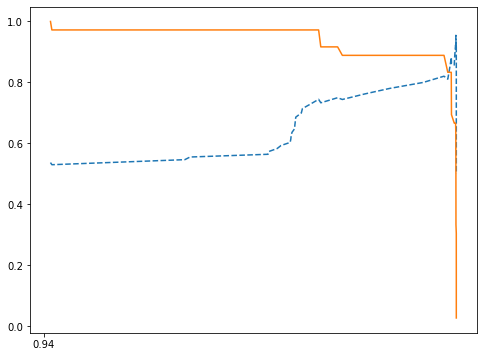

In [57]:
#Y_val,X_val_predict

precisions, recalls, thresholds = precision_recall_curve(Y_val,X_val_predict)

# 임계값 인덱스 지정
thr_index = np.arange(0, thresholds.shape[0], 15)

# 인덱스에 해당하는 정밀도, 재현율, 임계값 구하기
print('thresholds : ', np.round(thresholds[thr_index],2))
print('precisions : ', np.round(precisions[thr_index],3))
print('recalls : ', np.round(recalls[thr_index],3))



# 그래프 그리기
def precision_recall_curve_plot(y_real, pred_prob_1):
    precisions, recalls, thresholds = precision_recall_curve(y_real, pred_prob_1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0] # 마지막은 포함시키지 않겠다
    plt.plot(thresholds, precisions[0:threshold_boundary], '--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2)) # scale 0.1 단위
    
precision_recall_curve_plot(Y_val,X_val_predict)

In [58]:
def optimal_threshold_pr(precision, recall, threshs):
    f_score = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(f_score)
    print('Best Threshold=%f, F-Score=%.3f' % (threshs[ix], f_score[ix]))
    print('Best precision=%f, recall=%f' % (precision[ix], recall[ix]))

    return threshs[ix]
threshold_pr=optimal_threshold_pr(precisions, recalls, thresholds)

Best Threshold=0.998152, F-Score=0.857
Best precision=0.882353, recall=0.833333


<h2>임계값으로 test data에 적용</h2>

In [59]:
def result_threshold(predict,Y_test,threshold):
    Y=[]
    for i in range(len(predict)):
        if predict[i]>threshold:
            Y.append(1)
        else:
            Y.append(0)
    tp = 0
    tn = 0
    fp = 0
    fn = 0    
    for i in range(len(Y_test)):
        if Y[i] == 1 and Y_test[i] == 1:
            tn += 1
        elif Y[i] == 0 and Y_test[i] == 0:
            tp += 1
        elif Y[i] == 0 and Y_test[i] == 1:
            fn += 1
        elif Y[i] == 1 and Y_test[i] == 0:
            fp += 1
    print(tn,tp,fn,fp)
    return Y

<p>test</p>

In [60]:
Y_predict_roc=result_threshold(predict,Y_test,threshold_roc)

36 133896 0 26


In [61]:
Y_predict_pr=result_threshold(predict,Y_test,threshold_pr)

28 133920 8 2


<p>valiation</p>

In [62]:
Y_predict_roc=result_threshold(X_val_predict,Y_val,threshold_roc)

35 133891 1 31


In [63]:
Y_predict_pr=result_threshold(X_val_predict,Y_val,threshold_pr)

29 133918 7 4


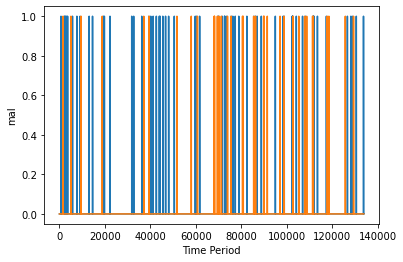

In [64]:
# Plot predictions
plt.plot(Y_predict_roc)
plt.plot(Y_test)
plt.xlabel("Time Period")
plt.ylabel("mal")
plt.show()

In [65]:
test_data=pd.read_csv('test_dataset_01.csv',error_bad_lines=False)

b'Skipping line 1000426: expected 22 fields, saw 23\n'
b'Skipping line 1279004: expected 22 fields, saw 23\n'
b'Skipping line 3023273: expected 22 fields, saw 27\n'
b'Skipping line 3074890: expected 22 fields, saw 27\n'
b'Skipping line 3460738: expected 22 fields, saw 23\n'


In [66]:
test_data=test_data.iloc[:,0:9]

In [67]:
test_data.columns=['_ws.col.UTCtime',"_ws.col.Protocol","ip.src","ip.dst","tcp.srcport","tcp.dstport","tcp.len","tcp.seq","tcp.ack"]

In [68]:
test_data=test_data.sort_values(by='_ws.col.UTCtime')

In [69]:
test_data['_ws.col.UTCtime']=pd.to_datetime(test_data['_ws.col.UTCtime'])
test_data['_ws.col.UTCtime']=test_data['_ws.col.UTCtime'].astype(np.int64)// 10**9

In [70]:
test_data['_ws.col.UTCtime']=test_data['_ws.col.UTCtime']-test_data.iloc[0,0]

In [71]:
test_data= test_data.dropna(axis=0) #결측값 삭제
test_data=test_data.astype({"_ws.col.UTCtime":'int','tcp.srcport': 'int','tcp.dstport': 'int','tcp.len': 'int','tcp.seq':'int','tcp.ack': 'int'})

In [73]:
groupset=[]
over_100_group=[]
gb = test_data.groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.srcport'])
for key, group in gb:
    group = np.asarray(group)
    if len(group)>100:
        over_100_group.append(group)
    else :
        groupset.append(group)

In [74]:
gb = test_data.groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.dstport'])
for key, group in gb:
    group = np.asarray(group)
    if len(group)>100:
        over_100_group.append(group)
    else :
        groupset.append(group)

In [75]:
for i in range(len(over_100_group)):
    for j in range(0,len(over_100_group[i]),100):
        groupset.append(over_100_group[i][j:j+100])

In [76]:
len(groupset)

409211

In [77]:
for i in range(len(groupset)):
    groupset[i][:,0]=groupset[i][:,0]-groupset[i][0][0]

In [79]:
X=[]
for i in range(len(groupset)):
    temp=np.delete(groupset[i],[1,2,3,4,5],1)
    num=100-len(temp)
    X.append(np.pad(temp,((0,num),(0,0)),'constant', constant_values=-1))

In [80]:
X_data=np.asarray(X)

In [82]:
X_data=X_data.astype('float32')
predict =model.predict(X_data, verbose=1)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
12788/12788 [==============================] - 49s 4ms/step
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0


In [83]:
def make_1(predict,threshold):
    Y=[]
    for i in range(len(predict)):
        if predict[i]>threshold:
            Y.append(1)
        else:
            Y.append(0)
    return Y

In [84]:
Y_predict_pr=make_1(predict,threshold_pr)

In [85]:
Y_predict_roc=make_1(predict,threshold_roc)

In [86]:
pr_attack=[]
for i in range(len(Y_predict_pr)):
    if Y_predict_pr[i]==1:
        pr_attack.append(i)

In [87]:
roc_attack=[]
for i in range(len(Y_predict_roc)):
    if Y_predict_roc[i]==1:
        roc_attack.append(i)

In [88]:
print(len(pr_attack),len(roc_attack))

77 156


In [89]:
for i in range(len(pr_attack)):
    print(groupset[pr_attack[i]][0][1],groupset[pr_attack[i]][0][2],groupset[pr_attack[i]][0][3],groupset[pr_attack[i]][0][4],groupset[pr_attack[i]][0][5])

FTP 172.16.0.1 192.168.10.50 52280 21
FTP 172.16.0.1 192.168.10.50 52290 21
FTP 172.16.0.1 192.168.10.50 52296 21
FTP 172.16.0.1 192.168.10.50 52298 21
FTP 172.16.0.1 192.168.10.50 52306 21
FTP 172.16.0.1 192.168.10.50 52308 21
FTP 172.16.0.1 192.168.10.50 52310 21
FTP 172.16.0.1 192.168.10.50 52322 21
FTP 172.16.0.1 192.168.10.50 52324 21
FTP 172.16.0.1 192.168.10.50 52326 21
FTP 172.16.0.1 192.168.10.50 52332 21
TCP 172.16.0.1 192.168.10.50 52278 21
TCP 172.16.0.1 192.168.10.50 52280 21
TCP 172.16.0.1 192.168.10.50 52282 21
TCP 172.16.0.1 192.168.10.50 52284 21
TCP 172.16.0.1 192.168.10.50 52286 21
TCP 172.16.0.1 192.168.10.50 52288 21
TCP 172.16.0.1 192.168.10.50 52292 21
TCP 172.16.0.1 192.168.10.50 52294 21
TCP 172.16.0.1 192.168.10.50 52296 21
TCP 172.16.0.1 192.168.10.50 52298 21
TCP 172.16.0.1 192.168.10.50 52300 21
TCP 172.16.0.1 192.168.10.50 52302 21
TCP 172.16.0.1 192.168.10.50 52304 21
TCP 172.16.0.1 192.168.10.50 52306 21
TCP 172.16.0.1 192.168.10.50 52308 21
TCP 172.16.0

In [90]:
import csv
f = open('test_00001_60_pr.csv','w', newline='')
wr = csv.writer(f)

In [91]:
for k in range(len(pr_attack)):
    i=pr_attack[k]
    wr.writerow([groupset[i][0][2],groupset[i][0][3],groupset[i][0][4],groupset[i][0][5],groupset[i][0][1]])

In [92]:
f.close()

In [93]:
import csv
f = open('test_00001_60_roc.csv','w', newline='')
wr = csv.writer(f)

In [94]:
for k in range(len(roc_attack)):
    i=roc_attack[k]
    wr.writerow([groupset[i][0][2],groupset[i][0][3],groupset[i][0][4],groupset[i][0][5],groupset[i][0][1]])

In [95]:
f.close()